In [4]:
import nbconvert

In [1]:
def pearson_similarity(active_user,other_user,ratings):
    active_loc = ratings.index.get_loc(active_user)
    other_loc = ratings.index.get_loc(other_user)
    active_mean_rating = ratings.iloc[active_loc,:].mean()
    other_mean_rating = ratings.iloc[other_loc,:].mean()
    numerator = 0
    num1 = 0
    num2 = 0
    den1 = 0
    den2 = 0
    denomenator = 0
    
    for i in range(0,len(ratings.columns)):
        
            
        num1 = ratings.iloc[active_loc,i] - active_mean_rating
        num2 = ratings.iloc[other_loc,i] - other_mean_rating
        numerator = numerator + (num1*num2)
        
        den1 = den1 + np.square(num1)
        den2 = den2 + np.square(num2)
        
    denomenator = np.sqrt(den1*den2)
    pearson_corr = numerator/denomenator
    
    return pearson_corr
        
def similar_users(user_id,ratings):
    
    correlation_list = []
    correlated_users_list = []
    
    for i in range(0,1000):
        corr = pearson_similarity(user_id,ratings.index[i],ratings)
        
        if(corr>0.5):
            correlation_list.append(corr)
            correlated_users_list.append(ratings.index[i])
        
    return correlation_list,correlated_users_list   

# Book recommendation engine



### Recommendation systems are also known as recommender systems or recommender engine. These are systems that help users discover items they may like. Recommendation systems have multitude of applications like product recommendations (like movies and videos, books, fashion items etc.), recommendations of news articles, job postings, Facebook friends, etc. Big companies are using these systems to generate large revenue.  Analysts estimate that already 35% of what consumers purchase on Amazon and 75%of what they watch on Netflix come from product recommendations based on recommendation algorithms. In this notebook i have build book recommendation engine which will recommend top-N books to the users. 

## Dataset overview



### The data we'll be using comes from the [Book-Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset has been compiled by Cai-Nicolas Ziegler in 2004, and it comprises of three tables for users, books and ratings. 

## Data exploration



### Before applying any model to the dataset we have to first understand what the data is and what information it contain. Data exploration reveals the hidden trends and insights and data preprocessing makes the data ready for use by ML algorithms.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import correlation, cosine
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation


### First, we load the dataset and check the shapes of books, users and ratings dataset as below:

In [3]:
df1 = pd.read_csv("users.txt",sep=";",encoding="UTF-8")
df2 = pd.read_csv("BX-Book-Ratings.csv",sep=";",encoding="latin-1")
df3 = pd.read_csv("BX-Books.csv",sep=";",error_bad_lines=False,encoding="latin-1")

b'Skipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
c:\users\dheeraj\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWa

In [4]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(278857, 3)
(1149780, 3)
(271361, 8)


## Books rating dataset



In [5]:
df2.head()

(1149780, 3)


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Book ratings have range from 0 to 10. Let's check the total value counts for each rating. This will give rough idea about the ratings which have been given most by the users.  

In [6]:
df2["Book-Rating"].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64

### As we can see vast majority of ratings are 0 only. Let's show this uneven distribution by plotting the graph.

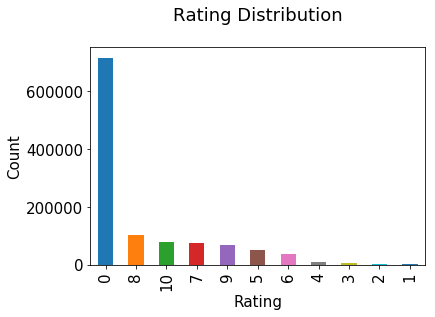

In [8]:
plt.rc("font",size="15")
df2["Book-Rating"].value_counts().plot(kind="bar")
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Let's filter out those books which are not present in the Books dataset

In [9]:
rating_data = df2[df2.ISBN.isin(df3.ISBN)]
print(rating_data.shape)
rating_data.head()

(1031136, 3)

### Let's filter out those books which have 0 rating

In [10]:
rating_data_new = rating_data[rating_data["Book-Rating"]>0]
print(rating_data_new.shape)
rating_data_new.head()

(383842, 3)

### Now after filtering out the  rating data we will plot the countplot of the ratings to check the total count of the ratings.

<function matplotlib.pyplot.show>

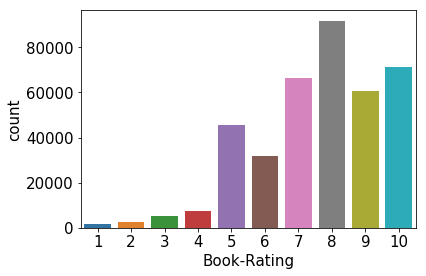

In [11]:
sns.countplot(data=rating_data_new, x = "Book-Rating")
plt.show

## users data



In [12]:
print(df1.shape)
print(list(df1.columns))
df1.head()

(278857, 3)
['User-ID', 'Location', 'Age\t\t\t\t\t\t\t\t']


,User-ID,Location,Age
0,1,nyc\t new york\t usa,NULL\t\t\t\t\t\t
1,2,stockton\t california\t usa,18\t\t\t\t\t\t
2,3,moscow\t yukon territory\t russia,NULL\t\t\t\t\t\t
3,4,porto\t v.n.gaia\t portugal,17\t\t\t\t\t\t
4,5,farnborough\t hants\t united kingdom,NULL\t\t\t\t\t\t


### As we can see that there is defect in the values of age column so we will use regular expression to replace the "\t" with nothing.     

In [13]:
df1 = df1.replace({'\$': '', '\t': ''}, regex=True)
df1.head()

,User-ID,Location,Age
0,1,nyc new york usa,NULL
1,2,stockton california usa,18
2,3,moscow yukon territory russia,NULL
3,4,porto v.n.gaia portugal,17
4,5,farnborough hants united kingdom,NULL


### Since column name is also defective so we will rename it.

In [14]:
df1 = df1.rename(index = str,columns={"Age\t\t\t\t\t\t\t\t":"Age"})
print(list(df1.columns))

['User-ID', 'Location', 'Age']


### As in the dataset we have observed that there are several null values so we will replace those null values          replacing null values with nan values. Later we will fill these nan values also.

In [15]:
df1 = df1.replace("NULL",np.NAN)
df1.head()

,User-ID,Location,Age
0,1,nyc new york usa,NaN
1,2,stockton california usa,18
2,3,moscow yukon territory russia,NaN
3,4,porto v.n.gaia portugal,17
4,5,farnborough hants united kingdom,NaN


### Let's check the unique values of age present in the users data. This will help us to know the range of user's age present in the users data.

In [16]:
(df1["Age"].unique())

array([nan, '18', '17', '61', '26', '14', '25', '19', '46', '55', '32',
       '24', '20', '34', '23', '51', '31', '21', '44', '30', '57', '43',
       '37', '41', '54', '42', '50', '39', '53', '47', '36', '28', '35',
       '13', '58', '49', '38', '45', '62', '63', '27', '33', '29', '66',
       '40', '15', '60', '0', '79', '22', '16', '65', '59', '48', '72',
       '56', '67', '1', '80', '52', '71', '73', '78', '9', '64', '103',
       '41"', '104', '12', '74', '69', '75', '231', '3', '76', '83', '68',
       '119', '11', '77', '2', '70', '93', '8', '7', '4', '81', '114',
       '230', '239', '10', '5', '148', '151', '6', '101', '201', '96',
       '84', '82', '90', '123', '244', '133', '91', '128', '23"', '94',
       '85', '141', '110', '97', '219', '86', '124', '92', '175', '172',
       '209', '212', '237', '87', '162', '100', '156', '52"', '136', '95',
       '89', '106', '99', '69"', '108', '210', '88', '28"', '199', '147',
       '35"', '168', '132', '159', '186', '18"', '152'

### As we can see that there is the defect in the values as some values contain unnecessary double and single quotes which will create problem later. So we will replace these with nothing by using regular expression.

In [17]:
df1["Age"] = df1["Age"].replace({'\$': '', '"': ''}, regex=True)

### Since data type of age is object here but it should be of integer. So we will convert it to integer.

In [18]:
df1["Age"] = pd.to_numeric(df1["Age"])
(df1["Age"].unique())

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  71.,  73.,  78.,   9.,  64., 103.,
       104.,  12.,  74.,  69.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,  77.,   2.,  70.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

### Let's filter out the users data. We will first replace ages which are greater than 90 and less than 5 by nan values. After this we fill these nan values by mean of the ages. 

In [20]:
df1.loc[(df1.Age > 90) | (df1.Age < 5),"Age"] = np.NAN
df1["Age"] = df1["Age"].fillna(round(df1["Age"].mean()))

In [21]:
print(sorted(df1["Age"].unique()))

[5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0]


## Books dataset

In [22]:
df3.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### We can see that it contain some columns such as url columns which are of no use for us. So will simply drop them from the data.

In [23]:
df3 = df3.drop(["Image-URL-S","Image-URL-M","Image-URL-L"],axis=1)
print(list(df3.columns))
df3.head()

['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


### Now let's check the unique values of the year of publication.

In [24]:
df3["Year-Of-Publication"].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '1999', '2000', '1995', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

### There are some incorrect entries in yearOfPublication. It looks like publisher names ‘DK Publishing Inc’ and ‘Gallimard’ have been incorrectly loaded as yearOfPublication in dataset due to some errors in csv file. Also, some of the values are strings and same years have been entered as numbers at some places. We will make necessary correction for these rows and set the data type for yearOfPublication as int.

In [25]:
df3.loc[df3["Year-Of-Publication"]=="DK Publishing Inc",:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209539,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221679,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [26]:
df3.loc[df3.ISBN == "0789466953",  "Year-Of-Publication" ] = 2000
df3.loc[df3.ISBN == "0789466953", "Book-Author"] =  "James Buckley"
df3.loc[df3.ISBN == "0789466953","Publisher"] = "DK Publishing Inc"
df3.loc[df3.ISBN == "0789466953","Book-Title"] = "DK Readers: Creating the X-Men  How Comic Books Come to Life (Level 4: Proficient Readers)"

In [27]:
df3.loc[df3.ISBN == "078946697X",  "Year-Of-Publication" ] = 2000
df3.loc[df3.ISBN == "078946697X", "Book-Author"] =  "Michael Teitelbaum"
df3.loc[df3.ISBN == "078946697X","Publisher"] = "DK Publishing Inc"
df3.loc[df3.ISBN == "078946697X","Book-Title"] = "DK Readers: Creating the X-Men  How Comic Books Come to Life  (Level 4: Proficient Readers)"

In [28]:
df3.loc[df3["Year-Of-Publication"]=="Gallimard",:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220732,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [29]:
df3.loc[df3.ISBN == "2070426769",  "Year-Of-Publication" ] = 2003
df3.loc[df3.ISBN == "2070426769", "Book-Author"] =  "Jean-Marie Gustave Le CIA?A"
df3.loc[df3.ISBN == "2070426769","Publisher"] = "Gallimard"
df3.loc[df3.ISBN == "2070426769","Book-Title"] = "Peuple du ciel suivi de 'Les Bergers"

In [30]:
df3["Year-Of-Publication"] = pd.to_numeric(df3["Year-Of-Publication"])

In [31]:
print(sorted(df3["Year-Of-Publication"].unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


### We can see that the year of publication ranges from 0 to 2050. As the dataset was built in 2004 so let's assume that years after 2005 are incorrect. We will replace these values with nan and then fill these nan values by mean of the years values.



In [32]:
df3.loc[(df3["Year-Of-Publication"]>2005) | (df3["Year-Of-Publication"]==0),"Year-Of-Publication"] = np.NAN

In [33]:
print(sorted(df3["Year-Of-Publication"].unique()))

[1920.0, 1941.0, 1942.0, 1951.0, 1952.0, 1953.0, 1956.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1965.0, 1966.0, 1968.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, nan, 1376.0, 1378.0, 1806.0, 1897.0, 1900.0, 1901.0, 1902.0, 1904.0, 1906.0, 1908.0, 1909.0, 1910.0, 1911.0, 1914.0, 1917.0, 1919.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1954.0, 1955.0, 1957.0, 1964.0, 1967.0, 1969.0, 2005.0]


In [34]:
df3["Year-Of-Publication"].fillna(np.abs(df3["Year-Of-Publication"].mean()),inplace=True)

In [35]:
df3["Year-Of-Publication"] = df3["Year-Of-Publication"].astype(np.int32)

In [36]:
print(sorted(df3["Year-Of-Publication"].unique()))

[1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005]


### Checking null values in publisher column and replacing them by "other".

In [37]:
df3.loc[df3.Publisher.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128891,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129038,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [38]:
df3.loc[df3.ISBN == "193169656X","Publisher"] = "other"
df3.loc[df3.ISBN == "1931696993","Publisher"] = "other"

In [39]:
df3["Publisher"].isnull().any()

False

In [40]:
df3 = df3.rename(index=str, columns={"Book-Title": "bookTitle"})

In [41]:
df3.head()

,ISBN,bookTitle,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


## Simple popularity based recommendation: 



### In this method  we will simply find the top 10 rated books by sorting the rating counts and then recommend those books to the users.

In [42]:
rating_count = pd.DataFrame(rating_data_new.groupby('ISBN')['Book-Rating'].count())
top_ratings = rating_count.sort_values('Book-Rating', ascending=False).head(10)
top_ratings.head()

,Book-Rating
ISBN,
0316666343,707
0971880107,581
0385504209,487
0312195516,383
0060928336,320


In [43]:
print("Following books are recommended:")
top_ratings.merge(df3,left_index=True,right_on="ISBN")

,Book-Rating,ISBN,bookTitle,Book-Author,Year-Of-Publication,Publisher
408,707,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
26,581,0971880107,Wild Animus,Rich Shapero,2004,Too Far
748,487,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,383,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
1105,320,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
2143,313,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
356,307,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
706,295,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
305,281,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company
231,278,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books


### As we can see above books are top ten rated books which are recommended for every user. "The Lovely Bones: A Novel" is the most rated book by the users followed by "Wild Animus" and so on. 

## Collaborative Filtering based Recommendation System

### In this we will [K-Nearest Neighbour algorithm](http://scikit-learn.org/stable/modules/neighbors.html) to find the k similar user or item and then by using the ratings given by those similar users we will make prediction. 

In [44]:
# merge the ratings data with book data
books_rating = rating_data_new.merge(df3,on="ISBN")
books_rating.head(10)

,User-ID,ISBN,Book-Rating,bookTitle,Book-Author,Year-Of-Publication,Publisher
0,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,2001,Doubleday
5,16877,038550120X,9,A Painted House,JOHN GRISHAM,2001,Doubleday
6,17975,038550120X,6,A Painted House,JOHN GRISHAM,2001,Doubleday
7,20806,038550120X,6,A Painted House,JOHN GRISHAM,2001,Doubleday
8,21340,038550120X,9,A Painted House,JOHN GRISHAM,2001,Doubleday
9,21356,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday


In [45]:
rating_count = books_rating.groupby("bookTitle")["Book-Rating"].count().reset_index().rename(columns = {"Book-Rating":"Total_Rating"})
rating_count.head(10)

,bookTitle,Total_Rating
0,A Light in the Storm: The Civil War Diary of ...,1
1,"Ask Lily (Young Women of Faith: Lily Series, ...",1
2,Dark Justice,1
3,Earth Prayers From around the World: 365 Pray...,7
4,Final Fantasy Anthology: Official Strategy Gu...,2
5,Flight of Fancy: American Heiresses (Zebra Ba...,1
6,Garfield Bigger and Better (Garfield (Numbere...,1
7,God's Little Promise Book,1
8,Good Wives: Image and Reality in the Lives of...,4
9,Goosebumps Monster Edition 1: Welcome to Dead...,3


In [46]:
books_rating_new = books_rating.merge(rating_count,left_on="bookTitle",right_on="bookTitle",how="left")
print(books_rating_new.shape)
books_rating_new.head()

(383842, 8)


,User-ID,ISBN,Book-Rating,bookTitle,Book-Author,Year-Of-Publication,Publisher,Total_Rating
0,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,5
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,1
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,1
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday,366
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,2001,Doubleday,366


In [47]:
print(len(books_rating_new["ISBN"].unique()))
print(len(books_rating_new["User-ID"].unique()))
print(149836*68091)

149836
68091
10202483076


### To cope up with computing power my machine has and to reduce the dataset size, I am considering users who have rated at least 50 books and books which have at least 50 ratings.

In [48]:
user_counts = books_rating_new["User-ID"].value_counts()
data_new = books_rating_new[books_rating_new["User-ID"].isin(user_counts[user_counts>50].index)]
books_counts = books_rating_new["Book-Rating"].value_counts()
data_final = data_new[data_new["Book-Rating"].isin(books_counts[books_counts>50].index)]
print(data_final.shape)
data_final.head()

(151924, 8)


,User-ID,ISBN,Book-Rating,bookTitle,Book-Author,Year-Of-Publication,Publisher,Total_Rating
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,2001,Doubleday,366
10,22625,038550120X,10,A Painted House,JOHN GRISHAM,2001,Doubleday,366
13,31315,038550120X,6,A Painted House,JOHN GRISHAM,2001,Doubleday,366
15,33974,038550120X,8,A Painted House,JOHN GRISHAM,2001,Doubleday,366
19,53220,038550120X,8,A Painted House,JOHN GRISHAM,2001,Doubleday,366


### Now we will impliment [User based collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering).  It predicts an active user‘s interest in a particular item based on rating information from similar user profiles, where each user profile corresponds to a row vector sorted in the user-item matrix. First, all similarities of any two row vectors are calculated. Then, for predicting the rating of a user for a particular item, a set of top-N similar users are identified. The ratings of those top-N users are averaged as the prediction by weighted.

### We will first create a user item rating matrix. As most of the values in ratings matrix are NaNs indicating absence of ratings and hence sparsity of data. Most of the machine learning algorithms cannot handle NaNs, we replace them with 0, which now indicates absence of rating.

In [49]:
rating_matrix = data_final.pivot(index="User-ID",columns="ISBN",values="Book-Rating")
userID = rating_matrix.index
ISBN = rating_matrix.columns
print(rating_matrix.shape)
rating_matrix.fillna(0,inplace = True)
rating_matrix = rating_matrix.astype(np.int32)
rating_matrix.head()

(1150, 85999)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B0000DYXID,B0000T6KHI,B0000T6KIM,B0000VZEJQ,B0000X8HIE,B00011SOXI,B00013AX9E,B0001GMSV2,B0001I1KOG,B000234N3A
User-ID,,,,,,,,,,,,,,,,,,,,,
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### The function similar_users input userID and rating matrix and returns similarities and indices of k similar users. As told earlier we will be using K-NearestNeighbour algorithm to find the k similar users. I have set k = 10 to find 10 most similar users.

### Now to find the similarities between users there are various similarity measures available such as cosine, Pearson, Euclidean etc.
### We will use [pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) to find the similarites between users.   

In [1]:
def similar_users(active_user,rating_matrix):
    active_loc = rating_matrix.index.get_loc(active_user)
    model_knn = NearestNeighbors(metric = 'correlation', algorithm = 'brute')
    model_knn.fit(rating_matrix)
    distances, indices =model_knn.kneighbors(rating_matrix.iloc[active_loc, :].values.reshape(1, -1), n_neighbors = 10)
    similarities = abs(distances.flatten()-1)
    indices = indices.flatten()
    ''''for i in range(0, len(distances.flatten())):
        if i == 0:
            print('similar_users for {0}:\n'.format(rating_matrix.index[active_loc]))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, rating_matrix.index[indices[i]], similarities[i]))'''
    
    return similarities, indices

### The function user_based_prediction inputd userID, itemID and rating matrix and returns the predicted rating which user will give to that particular item.  

In [5]:
def user_based_prediction(user_id,item_id,rating_matrix):
    user_loc = rating_matrix.index.get_loc(user_id)
    item_loc = rating_matrix.columns.get_loc(item_id)
    mean_rating_active_user = rating_matrix.iloc[user_loc,:].mean()
    similarities, indices = similar_users(user_id,rating_matrix)
    similarities_sum = np.sum(similarities)
    numerator=0
    
    for i in range(0,len(indices)):
        
        mean_rating_other_user = rating_matrix.iloc[indices[i],:].mean()
        num_1 = rating_matrix.iloc[user_loc,item_loc] - mean_rating_other_user
        num_2 = similarities[i]
        numerator = numerator + (num_1*num_2)
    
    rating1 = mean_rating_active_user + (numerator/similarities_sum)
    if rating1 < 1:
        rating1 = 1
    #print("\n")
    #print("prediction for user {0} item {1}: {2}".format(rating_matrix.index[user_loc],rating_matrix.columns[item_loc],rating1))
    return rating1 

In [52]:
prediction = user_based_prediction(227447,"0373711484",rating_matrix)
prediction

9.002151848893686

In [53]:
def recommend_userbased(user_id, ratings):    
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print ("User id should be a valid integer from this list :\n\n {} "
               .format(re.sub('[\[\]]', '', np.array_str(rating_matrix.index.values))))
    else:
        prediction = []
        for i in range(ratings.shape[1]):
            if (ratings[str(ratings.columns[i])][user_id] != 0):
                prediction.append(user_based_prediction(user_id, str(ratings.columns[i]) ,ratings))
            else:    
                prediction.append(-1) #for already rated items
        prediction = pd.Series(prediction)
        prediction = prediction.sort_values(ascending=False)
        recommended = prediction[:10]
        #print(recommended)
       # print ("As per {0} approach....Following books are recommended...".format(select.value))
        for i in range(len(recommended)):
            print ("{0}. {1}".format(i+1,df3["bookTitle"][recommended.index[i]].encode('utf-8')) )
    return prediction

In [54]:
predict_userbased = recommend_userbased(4385,rating_matrix)

17202    10.00122
19008    10.00122
18474    10.00122
16618    10.00122
17217    10.00122
17369    10.00122
17367    10.00122
73273    10.00122
27812    10.00122
42344    10.00122
dtype: float64
1. b'Captain Saturday: A Novel'
2. b'The good-by day (A Little golden book)'
3. b'Chasing the Dime'
4. b'Circle of Stones'
5. b'Who Killed Tiffany Jones? : A Novel'
6. b'The Long Silence of Mario Salviati : A Novel'
7. b'MY STORY'
8. b"Sandra Shamas: A Trilogy of Performances: My Boyfriend's Back and There's Gonna Be Laundry; The Cycle Continues; Wedding Bell Hell"
9. b'ARC OF LOVE : An Anthology of Lesbian Love Poems'
10. b'Tribe That Lost Its Head'


In [56]:
matrix = rating_matrix.T
matrix.head()

User-ID,254,638,1424,1733,1903,2033,2110,2276,2766,2891,...,274004,274061,274111,274301,275970,276680,277427,278137,278188,278418
ISBN,,,,,,,,,,,,,,,,,,,,,
0000913154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001046438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000104687X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001047213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001047973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
def similar_items(item_id,matrix):
    item_loc = matrix.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = 'correlation', algorithm = 'brute')
    model_knn.fit(matrix)
    distances, indices =model_knn.kneighbors(matrix.iloc[item_loc, :].values.reshape(1, -1), n_neighbors = 10)
    similarities = abs(distances.flatten()-1)
    indices = indices.flatten()
    ''''for i in range(0, len(distances.flatten())):
        if i == 0:
            print('similar_users for {0}:\n'.format(matrix.index[item_loc]))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, matrix.index[indices[i]], similarities[i]))'''
    
    return similarities, indices

In [58]:
def item_based_prediction(user_id,item_id,matrix):
    user_loc = matrix.columns.get_loc(user_id)
    item_loc = matrix.index.get_loc(item_id)
    similarities, indices = similar_items(item_id,matrix)
    numerator = 0
    for i in range(0,len(indices)):
    
        n1 = matrix.iloc[indices[i],user_loc] * similarities[i]
        numerator = numerator + n1
    
    denomenator = np.sum(similarities)

    rating = numerator/denomenator
    return rating 

In [59]:
item_based_prediction(92979,"843391460X",matrix)

5.2

In [60]:
def recommend_Itembased(user_id, ratings):    
    if (user_id not in ratings.columns.values) or type(user_id) is not int:
        print ("User id should be a valid integer from this list :\n\n {} ".
               format(re.sub('[\[\]]', '', np.array_str(rating_matrix.index.values))))
    else:
        prediction = []
        for i in range(ratings.shape[0]): 
            if (ratings[user_id][(ratings.index[i])] !=0):
                prediction.append(item_based_prediction(user_id, str(ratings.index[i]) ,ratings))
            else:    
                prediction.append(-1) #for already rated items
        prediction = pd.Series(prediction)
        prediction = prediction.sort_values(ascending=False)
        recommended = prediction[:10]
        #print(recommended)
        #print ("As per {0} approach....Following books are recommended...".format(select.value))
        for i in range(len(recommended)):
            print ("{0}. {1}".format(i+1,df3["bookTitle"][recommended.index[i]].encode('utf-8')))
    return prediction

In [61]:
import re
predict_itembased = recommend_Itembased(4385 ,matrix)

18514    9.918448
31859    9.908642
31914    9.907969
65448    9.903289
46314    9.902161
18418    9.902161
58217    9.728305
18744    9.618048
73081    9.618048
18743    9.618048
dtype: float64
1. b'Third Time Lucky (The Princess Diaries)'
2. b'One - Week Marriage (Harlequin Romance, 3559)'
3. b'Silk and Secrets'
4. b'Golden Fancy'
5. b'Human Touch  (Rita Award)'
6. b'Living Without Depression and Manic Depression: A Workbook for Maintaining Mood Stability (New Harbinger Workbooks)'
7. b"Annie's Coming Out"
8. b'It Came From The Far Side'
9. b'Cinders to Satin'
10. b'The Far Side Observer'


In [63]:
data_new = data_final.drop_duplicates(['User-ID', 'bookTitle'])
data_new.head()

,User-ID,ISBN,Book-Rating,bookTitle,Book-Author,Year-Of-Publication,Publisher,Total_Rating
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,2001,Doubleday,366
10,22625,038550120X,10,A Painted House,JOHN GRISHAM,2001,Doubleday,366
13,31315,038550120X,6,A Painted House,JOHN GRISHAM,2001,Doubleday,366
15,33974,038550120X,8,A Painted House,JOHN GRISHAM,2001,Doubleday,366
19,53220,038550120X,8,A Painted House,JOHN GRISHAM,2001,Doubleday,366


In [115]:
R_df = data_new.pivot(index="User-ID",columns="bookTitle",values="Book-Rating")
userID = R_df.index
ISBN = R_df.columns
print(R_df.shape)
R_df.fillna(0,inplace = True)
R_df = R_df.astype(np.int32)
R_df.head()

(1150, 79046)


bookTitle,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)","Ask Lily (Young Women of Faith: Lily Series, Book 5)",Dark Justice,"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",Final Fantasy Anthology: Official Strategy Guide (Brady Games),Flight of Fancy: American Heiresses (Zebra Ballad Romance),"Good Wives: Image and Reality in the Lives of Women in Northern New England, 1650-1750","Goosebumps Monster Edition 1: Welcome to Dead House, Stay Out of the Basement, and Say Cheese and Die!",Highland Desire (Zebra Splendor Historical Romances),"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",...,"wet sand, raven tracks",whataboutrick.com: a poetic tribute to Richard A. Ricci,why I'm like this : True Stories,"Â¡Corre, perro, corre!",Â¿Eres tu mi mamÃ¡?/Are You My Mother?,Ã?ngeles fugaces (Falling Angels),Ã?Â?ber das Fernsehen.,Ã?Â?ber die Freiheit.,Ã?Â?berallnie. AusgewÃ?Â¤hlte Gedichte 1928 - 1965.,Ã?Â?rger mit Produkt X. Roman.
User-ID,,,,,,,,,,,,,,,,,,,,,
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R.astype("float") #- user_ratings_mean.reshape(-1, 1)

In [141]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 600)

In [142]:
sigma = np.diag(sigma)

In [143]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)# + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns, index = R_df.index)
preds_df.head()

bookTitle,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)","Ask Lily (Young Women of Faith: Lily Series, Book 5)",Dark Justice,"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",Final Fantasy Anthology: Official Strategy Guide (Brady Games),Flight of Fancy: American Heiresses (Zebra Ballad Romance),"Good Wives: Image and Reality in the Lives of Women in Northern New England, 1650-1750","Goosebumps Monster Edition 1: Welcome to Dead House, Stay Out of the Basement, and Say Cheese and Die!",Highland Desire (Zebra Splendor Historical Romances),"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",...,"wet sand, raven tracks",whataboutrick.com: a poetic tribute to Richard A. Ricci,why I'm like this : True Stories,"Â¡Corre, perro, corre!",Â¿Eres tu mi mamÃ¡?/Are You My Mother?,Ã?ngeles fugaces (Falling Angels),Ã?Â?ber das Fernsehen.,Ã?Â?ber die Freiheit.,Ã?Â?berallnie. AusgewÃ?Â¤hlte Gedichte 1928 - 1965.,Ã?Â?rger mit Produkt X. Roman.
User-ID,,,,,,,,,,,,,,,,,,,,,
254,-0.059488,0.023588,0.001406,0.028217,0.003373,-0.025731,0.057750,-0.009282,-0.013826,-0.001990,...,-0.003032,-0.001895,-0.071150,-0.003789,0.009430,-0.006082,-0.003032,-0.020155,0.000458,-0.000200
638,-0.013905,-0.011140,-0.001893,-0.143991,0.005542,0.204843,-0.059761,0.002078,-0.020723,0.063253,...,-0.001979,-0.001237,0.185042,-0.002474,0.008295,0.004434,-0.001979,-0.004479,-0.001950,-0.003024
1424,0.012285,0.022876,-0.001452,-0.012491,0.025652,0.004048,-0.033252,0.010876,-0.007182,-0.010573,...,0.008791,0.005495,-0.078509,0.010989,0.032215,-0.001293,0.008791,-0.007789,0.000661,-0.007753
1733,0.041485,-0.081638,0.006679,0.025025,-0.004567,0.613714,0.004975,0.047910,0.010071,-0.004417,...,0.000263,0.000165,-0.187464,0.000329,0.006905,0.014885,0.000263,0.037470,-0.008657,-0.021508
1903,0.000799,-0.090774,-0.000306,0.017296,-0.007854,0.020963,0.000586,0.040201,0.002893,-0.006624,...,0.000049,0.000030,-0.125380,0.000061,0.022548,-0.014418,0.000049,0.007472,0.003436,-0.002113


In [198]:
def svd_recommendation(userID,data_new,preds_df):
    user_row_number = preds_df.index.get_loc(userID)
    sorted_user_prediction = preds_df.iloc[user_row_number].sort_values(ascending = False)
    user_data = data_new[data_new["User-ID"] == (userID)].sort_values(by = "Book-Rating",ascending = False)
    print ('User {0} has already rated {1} movies.'.format(userID, user_data.shape[0]))
    recommendation = data_new[~data_new["bookTitle"].isin(user_data["bookTitle"])]
    recommendation = recommendation.merge(pd.DataFrame(sorted_user_prediction).
                                          reset_index(), how = 'left',left_on = 'bookTitle',right_on = 'bookTitle')
    recommendation = recommendation .rename(columns = {userID:"predictions"})                 
    recommendation = recommendation.sort_values(by = "predictions",ascending = False)
    recommended_books = recommendation.drop_duplicates(subset = "bookTitle").head(10)
    recommended_books = recommended_books["bookTitle"]
    return list(recommended_books)
    

In [202]:
svd_recommendation(4385,data_new,preds_df)

User 4385 has already rated 211 movies.


['Slow Heat in Heaven',
 "Love's Encore",
 'Lone Star Baby  (Heart Of Texas) (Harlequin Promo , No 6)',
 "Caroline's Child",
 'Dr. Texas (Heart of Texas)',
 'Wild Orchids',
 'The Thrill of Victory',
 'Texas! Lucky',
 "Nell's Cowboy",
 'Comes the Blind Fury']